In [1]:
import sys
sys.path.append('../src/')
from calibrate import *

In [2]:
import numpy as np
import calibrate as clb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
N = 5000
n_bins = 10
split_p = 0.5
train_N = int(N*split_p)
test_N = N - train_N
K = 2 
X, y = make_classification(
    n_samples=N, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = train_N  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=test_N,
)

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (rfc, "Random forest"),
]

bins = np.linspace(0,1,n_bins+1)


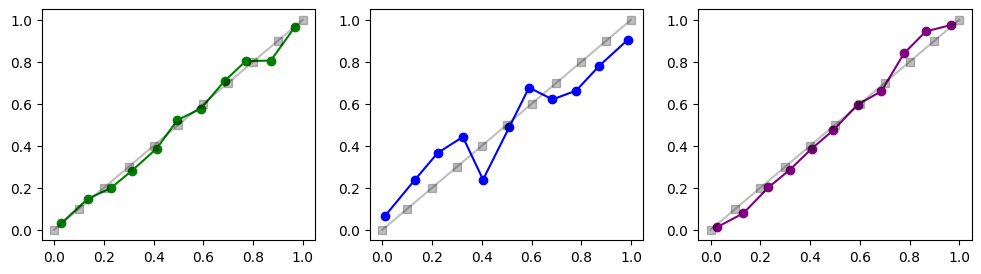

In [4]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
colors = ["green","blue", "purple"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)    
    y_pred = clf.predict_proba(X_test)[:,1]
    acc, conf = calibration_curve(y_test, y_pred, n_bins=n_bins+1)
    ax[i].plot(conf, acc, marker="o", color=colors[i])
    ax[i].plot(bins, bins, marker="s", color="black", alpha=0.25 )

In [7]:
bins = np.linspace(0,1,n_bins+1)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    cal_dists = []

    #Get the probability of belonging to the Y=1 class 
    pos_pred = clf.predict_proba(X_test)[:,1]
    
    #snap scores to bins 
    bin_pred = snap(pos_pred, bins=bins).reshape(-1, 1)

    _, p_count = np.unique(bin_pred, return_counts=True)
    p_freq = p_count/np.sum(p_count)


    # transportPlan = sinkhornTransport(y_freq, cal_dists[k], bins)
    # transportedScores = applyTransportPlan(y_snap, transportPlan, bins)

## Idea Number 1:
##### Compute the calibrated P(f(x)|Y=1) and  P(f(x)|Y=0), combine using bayes rule

Does it Work: <span style="color:red">No (lol)</span>.  
Reasoning: Turns out that the marginal distribution Pr(f(x)) is unchanged after we calibrate the conditionals -- said differently 

P_cal(f(x)) = P(f(x)) despite the fact that 

 P_cal(f(x)|Y) != P(f(x)|Y)



see the below:

First i'll compute the calibrated score distributions using the Bayes Rule Trick


 <span style="color:red">TODOS:</span> Make sure this hold for a larger bin size and for all classifier combinations -- when the sample size is low, the result doesn't hold absolutely, really only holds n -> infty 


In [8]:
clb_neg = calibratedConditional(P=p_freq, y=y_test, k=0, bins=bins)
clb_pos = calibratedConditional(P=p_freq, y=y_test, k=1, bins=bins)

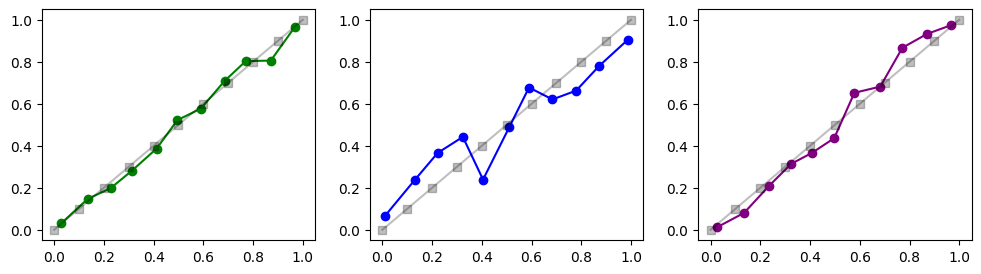

In [5]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
colors = ["green","blue", "purple"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)    
    y_pred = clf.predict_proba(X_test)[:,1]
    acc, conf = calibration_curve(y_test, y_pred, n_bins=n_bins+1)
    ax[i].plot(conf, acc, marker="o", color=colors[i])
    ax[i].plot(bins, bins, marker="s", color="black", alpha=0.25 )

If we print out the different in the PDFs for the pos/neg calibrated distributions, and the unclibrated conditional distributions, we'll see they're a little bit different 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


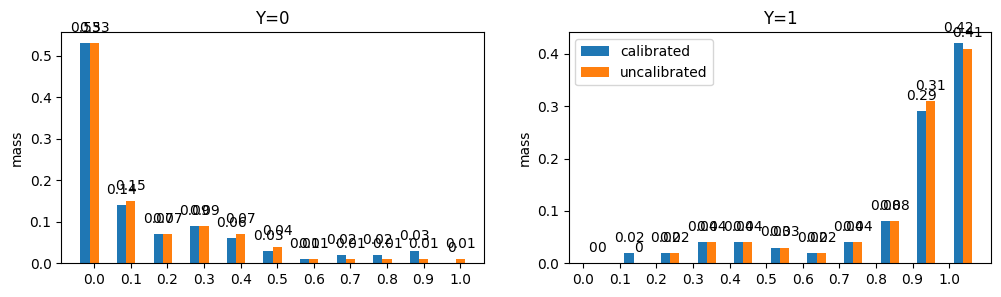

In [10]:
x = np.arange(len(bins))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(1,2,figsize=(12,3))
pmfs = [
{
    'calibrated': clb_neg,
    'uncalibrated': binPMF(bin_pred, y_test, bins, k=0)
}, 
{
    'calibrated': clb_pos,
    'uncalibrated': binPMF(bin_pred, y_test, bins, k=1)
}
]

#Code adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
for i in range(2):
    pmf_i = pmfs[i]
    for cal_status, pmf in pmf_i.items():
        offset = width * multiplier
        rects = ax[i].bar(x + offset, np.round(pmf,2), width, label=cal_status)
        ax[i].bar_label(rects, padding=6)
        multiplier += 1

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[i].set_ylabel('mass')
        ax[i].set_title('Y=%d' % i)
        ax[i].set_xticks(x + width, np.round(bins,2))
    ax[-1].legend()
plt.show()

So clearly the conditional distributions are different. However if we combine the conditional distributions using bayes rule, and compare P(f(x)) and P_cal(f(x)), we'll see that they're the same 

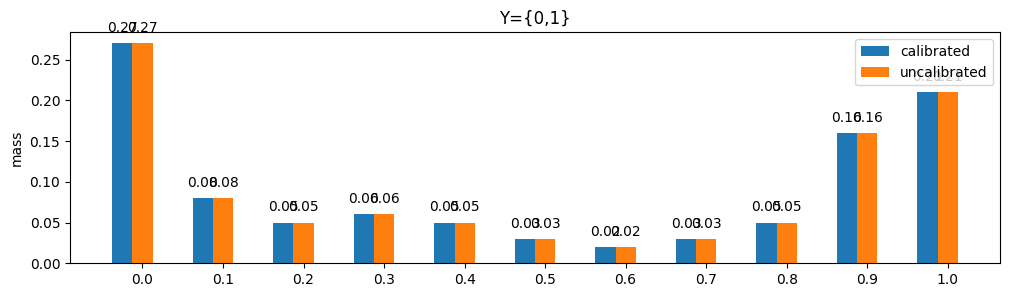

In [11]:
x = np.arange(len(bins))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(1,1,figsize=(12,3))
pmfs = {
    'calibrated': np.mean(y_test == 1)*clb_pos + np.mean(y_test == 0)*clb_neg, 
    'uncalibrated': binPMF(bin_pred, y_test, bins)
}


#Code adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

for cal_status, pmf in pmfs.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(pmf,2), width, label=cal_status)
    ax.bar_label(rects, padding=6)
    multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mass')
ax.set_title('Y={0,1}')
ax.set_xticks(x + width, np.round(bins,2))
ax.legend()

plt.show()

# Idea 2: Proof of Concept 

Using the test labels, we can optimal transport each conditional distribution into its calibrated counterpart.  See the illustration below.  

../src/calibrate.py:95: RuntimeWarning: invalid value encountered in divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in divide
  resid_values = np.divide(greedy_distr, mass)


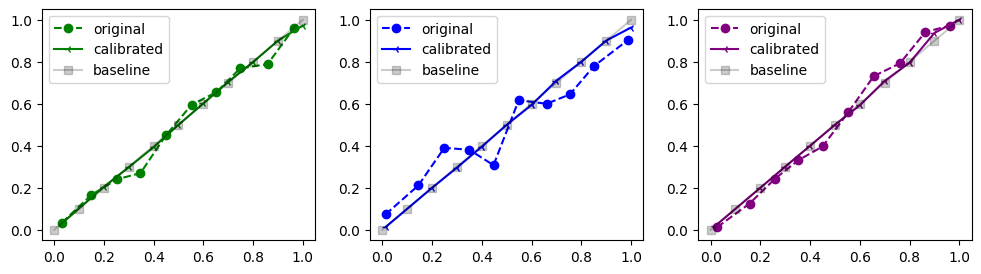

In [12]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    cal_dists = []

    # Get the probability of belonging to the Y=1 class
    pos_pred = clf.predict_proba(X_test)[:, 1]

    # snap scores to bins
    bin_pred = snap(pos_pred, bins=bins).reshape(-1, 1)

    transported = bin_pred.copy()
    transportPlans = getKTransportPlans(scores=bin_pred, y=y_test, K=2, bins=bins)
    for k in range(K):
        transported = applyTransportPlan(a=transported, M=transportPlans[k], y=y_test, k=k, bins=bins)

    y_pred = clf.predict_proba(X_test)[:,1]
    acc, conf = calibration_curve(y_test, y_pred, n_bins=n_bins)
    ax[i].plot(conf, acc, marker="o", color=colors[i], linestyle='--', label="original")

    clb_acc, clb_conf = calibration_curve(y_test, transported, n_bins=n_bins)
    ax[i].plot(clb_conf, clb_acc, marker="3", color=colors[i], label="calibrated")

    ax[i].plot(bins, bins, marker="s", color="black", alpha=0.2, label="baseline")
    ax[i].legend()


# Idea 3: Calibrate Using Predicted Labels 

In practice however we don't have the true labels, so lets try this using the predicted labels to see how much it works. 

Does it Work: <span style="color:#D7DF01">kinda?</span> 

Observations: I'm surprised @ how bad it is -- with that said the classifier accuracy is <90% so clearly if we have a bad classifier we're not going to have a great time doing this. (accuracy calculation is the next cell)

../src/calibrate.py:95: RuntimeWarning: invalid value encountered in divide
  resid_values = np.divide(greedy_distr, mass)


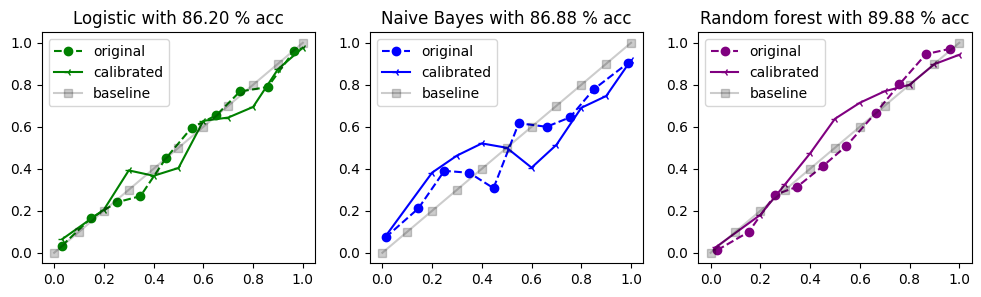

In [13]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    cal_dists = []

    # Get the probability of belonging to the Y=1 class
    pos_pred = clf.predict_proba(X_test)[:, 1]
    y_lab = clf.predict(X_test)
    ax[i].set_title("%s with %.2f %% acc" % (name, 100*accuracy_score(y_test, y_lab.astype(int))))    # snap scores to bins
    bin_pred = snap(pos_pred, bins=bins).reshape(-1, 1)

    transported = bin_pred.copy()
    transportPlans = getKTransportPlans(scores=bin_pred, y=y_lab, K=2, bins=bins)
    for k in range(K):
        transported = applyTransportPlan(a=transported, M=transportPlans[k], y=y_lab, k=k, bins=bins)

    y_pred = clf.predict_proba(X_test)[:,1]
    acc, conf = calibration_curve(y_test, y_pred, n_bins=n_bins)
    ax[i].plot(conf, acc, marker="o", color=colors[i], linestyle='--', label="original")

    clb_acc, clb_conf = calibration_curve(y_test, transported, n_bins=n_bins)
    ax[i].plot(clb_conf, clb_acc, marker="3", color=colors[i], label="calibrated")

    ax[i].plot(bins, bins, marker="s", color="black", alpha=0.2, label="baseline")
    ax[i].legend()


Now lets improve the classifier performance and see if that makes the calibratin any better? 
Hint:  <span style="color:blue">it does?</span>

../src/calibrate.py:95: RuntimeWarning: invalid value encountered in divide
  resid_values = np.divide(greedy_distr, mass)
../src/calibrate.py:95: RuntimeWarning: invalid value encountered in divide
  resid_values = np.divide(greedy_distr, mass)


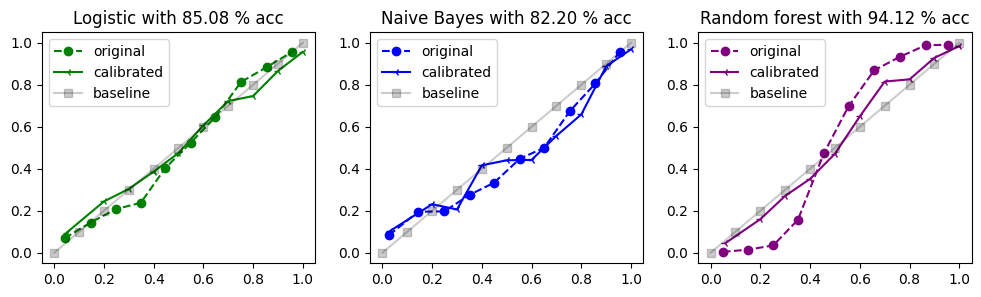

In [15]:
N = 5000
n_bins = 10
split_p = 0.5
train_N = int(N*split_p)
test_N = N - train_N
K = 2 
X, y = make_classification(
    n_samples=N, n_features=20, n_informative=10, n_redundant=2, random_state=42
)

train_samples = train_N  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=test_N,
)

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (rfc, "Random forest"),
]

bins = np.linspace(0,1,n_bins+1)

fig, ax = plt.subplots(1,3,figsize=(12,3))
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    cal_dists = []

    # Get the probability of belonging to the Y=1 class
    pos_pred = clf.predict_proba(X_test)[:, 1]
    y_lab = clf.predict(X_test)
    ax[i].set_title("%s with %.2f %% acc" % (name, 100*accuracy_score(y_test, y_lab.astype(int))))    # snap scores to bins
    bin_pred = snap(pos_pred, bins=bins).reshape(-1, 1)

    transported = bin_pred.copy()
    transportPlans = getKTransportPlans(scores=bin_pred, y=y_lab, K=2, bins=bins)
    for k in range(K):
        transported = applyTransportPlan(a=transported, M=transportPlans[k], y=y_lab, k=k, bins=bins)

    y_pred = clf.predict_proba(X_test)[:,1]
    acc, conf = calibration_curve(y_test, y_pred, n_bins=n_bins)
    ax[i].plot(conf, acc, marker="o", color=colors[i], linestyle='--', label="original")

    clb_acc, clb_conf = calibration_curve(y_test, transported, n_bins=n_bins)
    ax[i].plot(clb_conf, clb_acc, marker="3", color=colors[i], label="calibrated")

    ax[i].plot(bins, bins, marker="s", color="black", alpha=0.2, label="baseline")
    ax[i].legend()


# Multiclass Attempt #1 

Lets visualize the score distributions for each group 

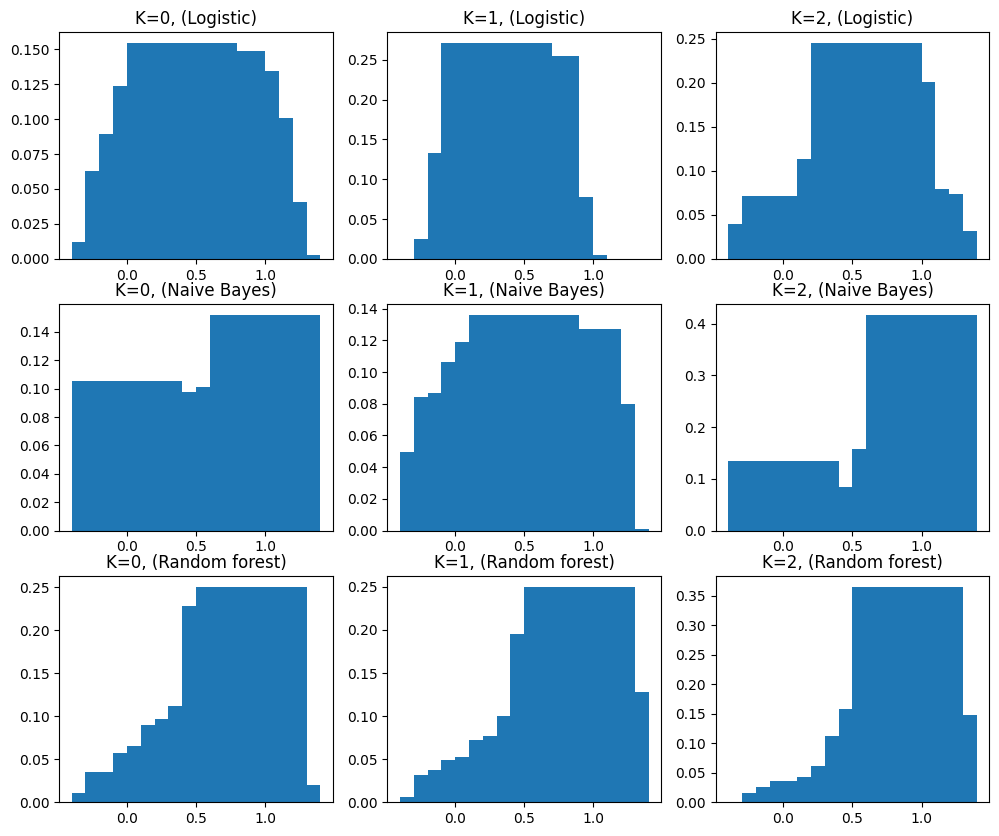

In [52]:
N = 5000
n_bins = 10
split_p = 0.5
train_N = int(N*split_p)
test_N = N - train_N
K = 3
X, y = make_classification(
    n_samples=N, n_features=20, n_informative=3, n_redundant=3, random_state=42, n_classes = K
)

train_samples = train_N  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=test_N,
)

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (rfc, "Random forest"),
]


fig, ax = plt.subplots(3,3,figsize=(12,10))
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    for k in range(K):
        bin_pred = snap(y_pred[:,k], bins=bins).reshape(-1, 1)
        bars = binPMF(bin_pred, y_test, bins=bins,k=k)
        ax[i,k].bar(bins,bars)
        ax[i,k].set_title("K=%d, (%s)" % (k, name))

The classwise reliability diagrams are as follows

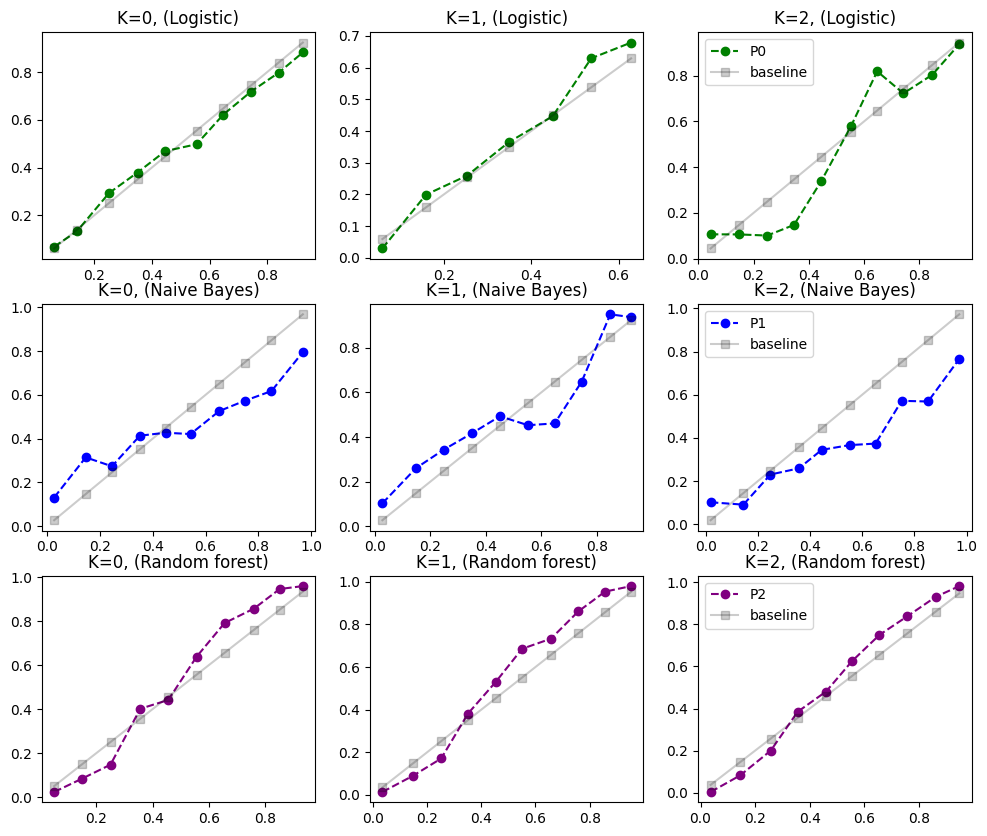

In [57]:
fig, ax = plt.subplots(3,3,figsize=(12,10))
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    for k in range(K):
        yk_mask = (y_test == k).astype(int)
        yk_pred = y_pred[:,k]
        acc, conf = calibration_curve(yk_mask, yk_pred, n_bins=n_bins)
        ax[i,k].plot(conf, acc, marker="o", color=colors[i], linestyle='--', label="P%d" % (i))
        ax[i,k].plot(conf, conf, marker="s", color="black", alpha=0.2, label="baseline")
        ax[i,k].set_title("K=%d, (%s)" % (k, name))
    ax[i,k].legend()